## Flu trends dataset: Understanding your data and applying the ARIMA model

This notebook contains the tasks to analyze the flu trends dataset and to apply the ARIMA model on it. The dataset contains the Google Trends data for various flu-related search terms as well as the weekly office visits for the flu (FluVisits column). You can find the dataset in data/flu_trends.csv. Install required packages and complete the notebook.

Throughout the seminar, we will use the following splits for training, validation, and testing. Make sure to keep the tests unseen until the final evaluation (information leakage):
- Training set: 2009-2013
- Validation set: 2014
- Test set: 2015-2016

Required python packages: pandas, numpy, matplotlib, scikit-learn, statsmodels, pmdarima

In [48]:
# Install required packages

In [49]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import pmdarima as pm
import os


## Task 1: Data Exploration

**Task 1.1:** Load the dataset and display the first few rows to understand the structure of the data. Check the data types of each column and convert the week column to a more usable datetime format.

In [50]:
filepath = os.path.join('..', 'data', 'raw', 'flu-trends.csv')

In [51]:
flu_data_testing = pd.read_csv(filepath)
flu_data_testing[["start_date", "end_date"]] = flu_data_testing["Week"].str.split("/", expand=True)
flu_data_testing["start_date"] = pd.to_datetime(flu_data_testing["start_date"], format="%Y-%m-%d")
flu_data_testing["end_date"]   = pd.to_datetime(flu_data_testing["end_date"], format="%Y-%m-%d")

df = flu_data_testing.set_index(["start_date", "end_date"])
df.drop(columns=["Week"], inplace=True)
df.head(10)


#We decided to keep the start and end date as a multi-index to make it easier to use while still keeping all the information.

,,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
start_date,end_date,,,,,,,,,,,,,,,,,,,,,
2009-06-29,2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06,2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13,2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20,2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27,2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120
2009-08-03,2009-08-09,28,23,39,8,6,18,13,8,7,8,...,8,9,16,18,30,13,26,26,17,115
2009-08-10,2009-08-16,29,22,41,35,10,17,15,7,10,8,...,8,11,10,28,32,21,17,25,13,123
2009-08-17,2009-08-23,29,20,43,32,9,20,20,10,13,22,...,8,9,10,24,29,13,23,27,14,205
2009-08-24,2009-08-30,27,19,52,27,7,22,16,13,16,19,...,15,13,18,26,43,29,27,26,17,454


**Task 1.2:** Are there any missing values in the dataset? If so, how would you handle them?

In [52]:
df.isna().sum()

AInfluenza                 0
AcuteBronchitis            0
BodyTemperature            0
BraunThermoscan            0
BreakAFever                0
                          ..
TypeAInfluenza             0
UpperRespiratory           0
WalkingPneumonia           0
WhatToDoIfYouHaveTheFlu    0
FluVisits                  0
Length: 130, dtype: int64

In [53]:
df.where(df >= 0, np.nan).isna().sum().sum()

0

There are no nans/negative numbers in the Dataframe. If there were, we could either drop the rows with nans, which would lead to holes in the time series and maybe to problems further down the line. 
Alternatively, we could fill the nans with the mean or median of the respective column, which might also be problematic, as there are probably seasonal trends in the data that both median and mean would not capture. 
A more sophisticated approach would be to use interpolation between neighbors to fill the nans.

**Task 1.3:** Provide summary statistics for the dataset.

In [54]:
df.describe()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,...,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,12.478142,44.683060,59.926230,31.836066,27.565574,43.428962,39.510929,24.844262,18.478142,11.270492,...,12.412568,7.275956,14.382514,38.439891,33.081967,13.352459,53.292350,50.844262,12.904372,386.745902
std,13.648556,17.114861,11.346958,11.087963,13.876355,15.097097,15.631322,16.294391,14.847842,11.276381,...,12.353991,6.586647,10.913163,11.130383,12.352754,16.965358,16.785163,17.100519,12.735416,616.914602
min,2.000000,14.000000,36.000000,8.000000,6.000000,17.000000,11.000000,3.000000,1.000000,2.000000,...,3.000000,1.000000,2.000000,15.000000,13.000000,1.000000,17.000000,22.000000,0.000000,10.000000
25%,4.000000,32.000000,50.000000,25.000000,19.000000,31.000000,28.000000,12.000000,8.000000,5.000000,...,5.000000,3.000000,8.000000,30.000000,24.000000,4.000000,41.000000,36.000000,6.000000,37.250000
50%,7.000000,43.000000,60.000000,30.000000,25.000000,42.500000,37.000000,22.000000,15.000000,8.000000,...,8.000000,6.000000,12.000000,37.000000,30.000000,6.000000,52.000000,49.000000,9.000000,106.000000
75%,14.000000,55.000000,68.000000,37.000000,32.750000,53.000000,50.000000,33.000000,23.000000,13.000000,...,15.000000,9.000000,17.000000,45.750000,40.000000,14.000000,66.000000,63.000000,14.000000,435.500000
max,82.000000,100.000000,100.000000,88.000000,100.000000,100.000000,100.000000,100.000000,100.000000,87.000000,...,93.000000,53.000000,81.000000,74.000000,87.000000,100.000000,100.000000,100.000000,89.000000,4070.000000


In [55]:
df.shape

(366, 130)

**Task 1.4:** Plot the weekly FluVisits over time to visualize trends and patterns. Compare with a few of the search trends. What do you observe?

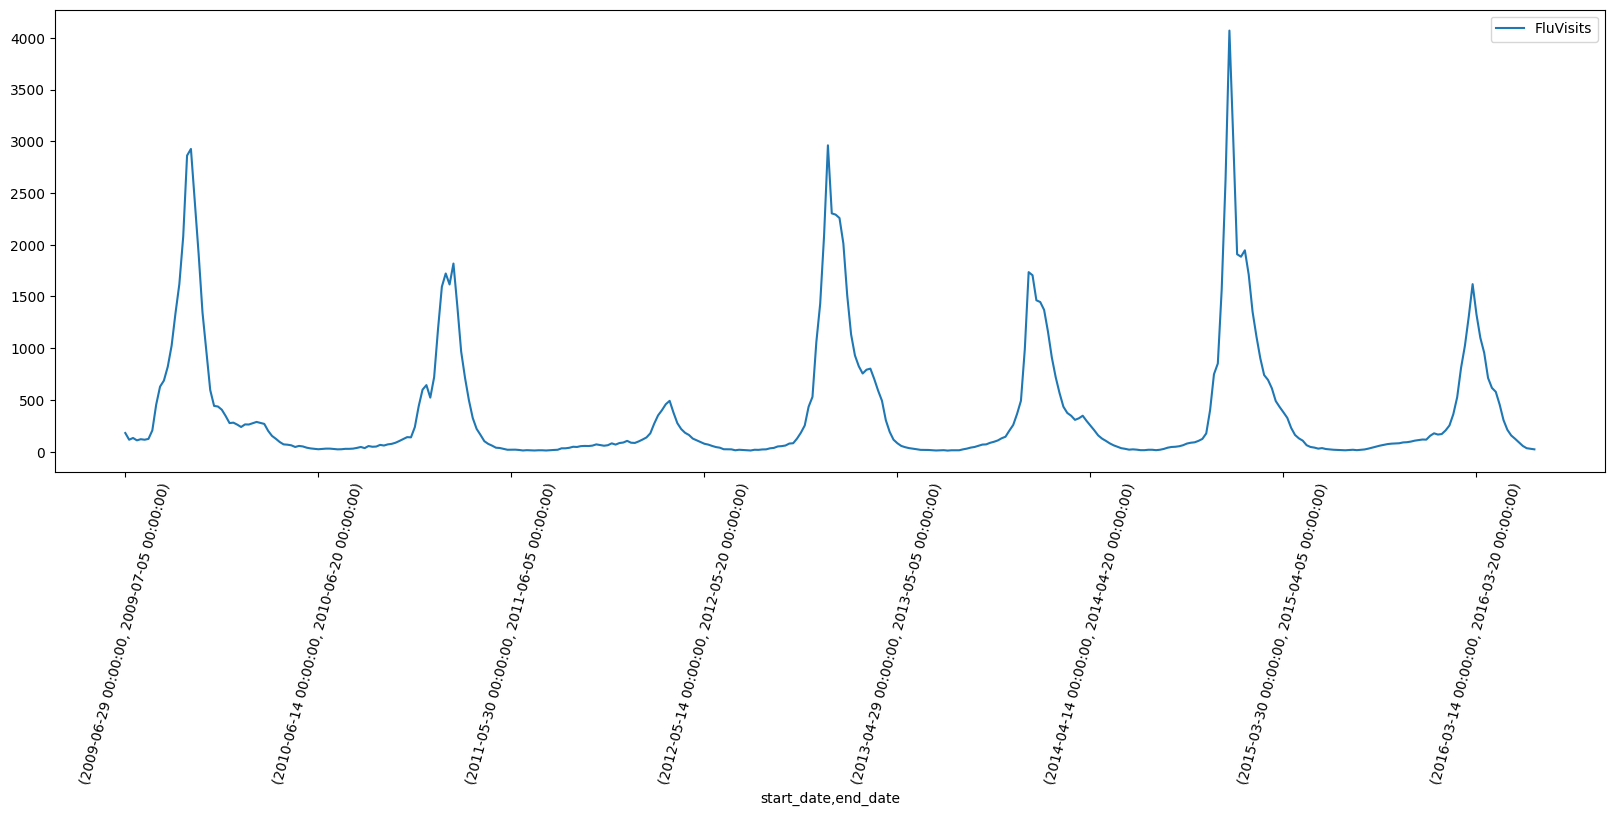

In [56]:
ax = df.plot(y='FluVisits', use_index=True, figsize=(20, 6))

ax.tick_params(axis='x', rotation=75)
plt.show()

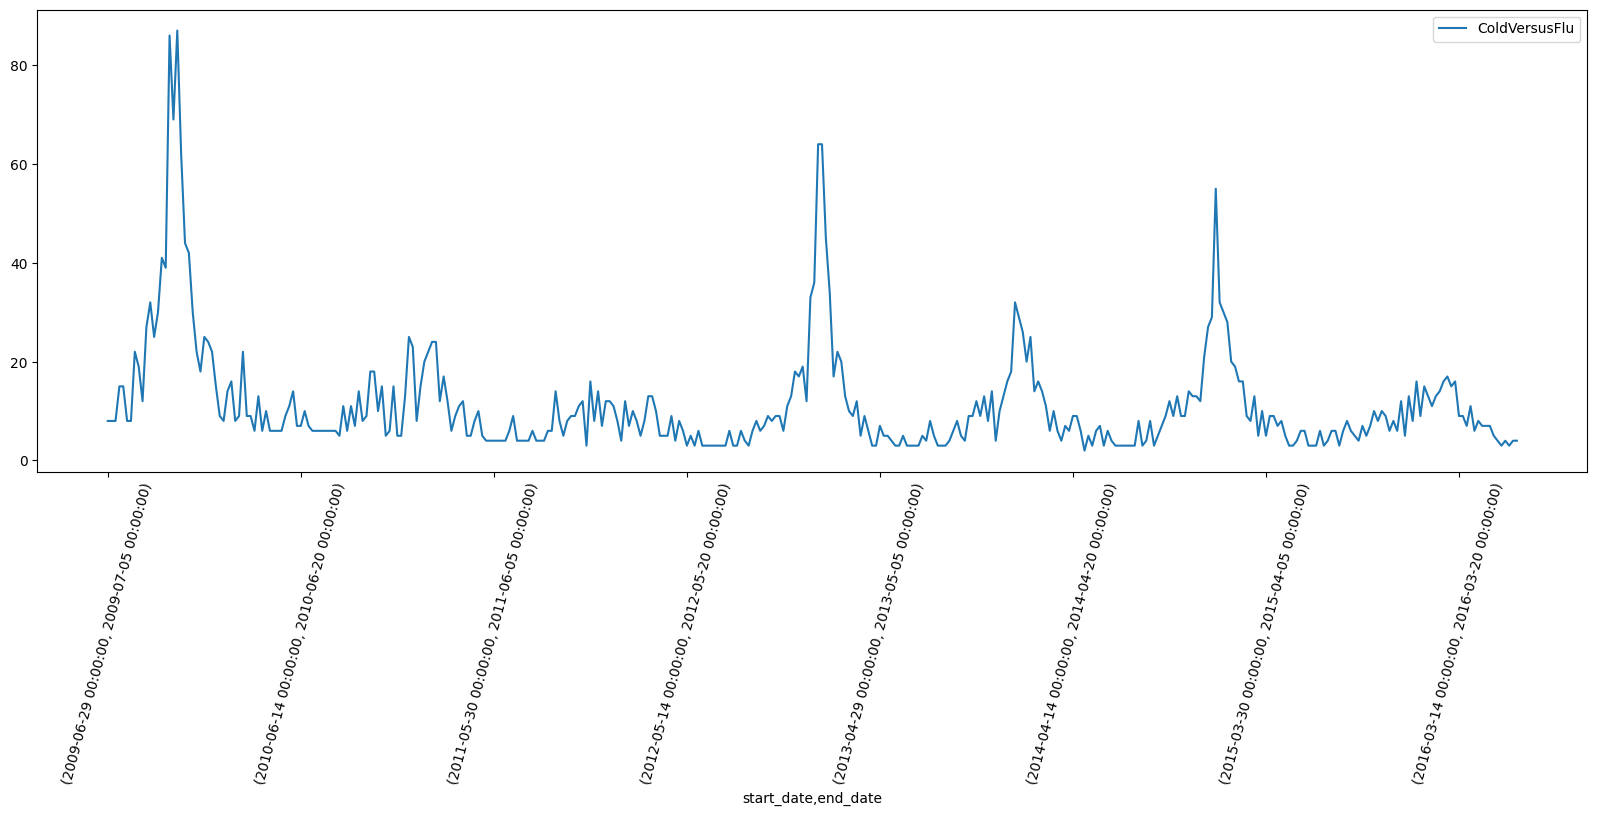

In [57]:
ax = df.plot(y='ColdVersusFlu', use_index=True, figsize=(20, 6))
ax.tick_params(axis='x', rotation=75)
plt.show()


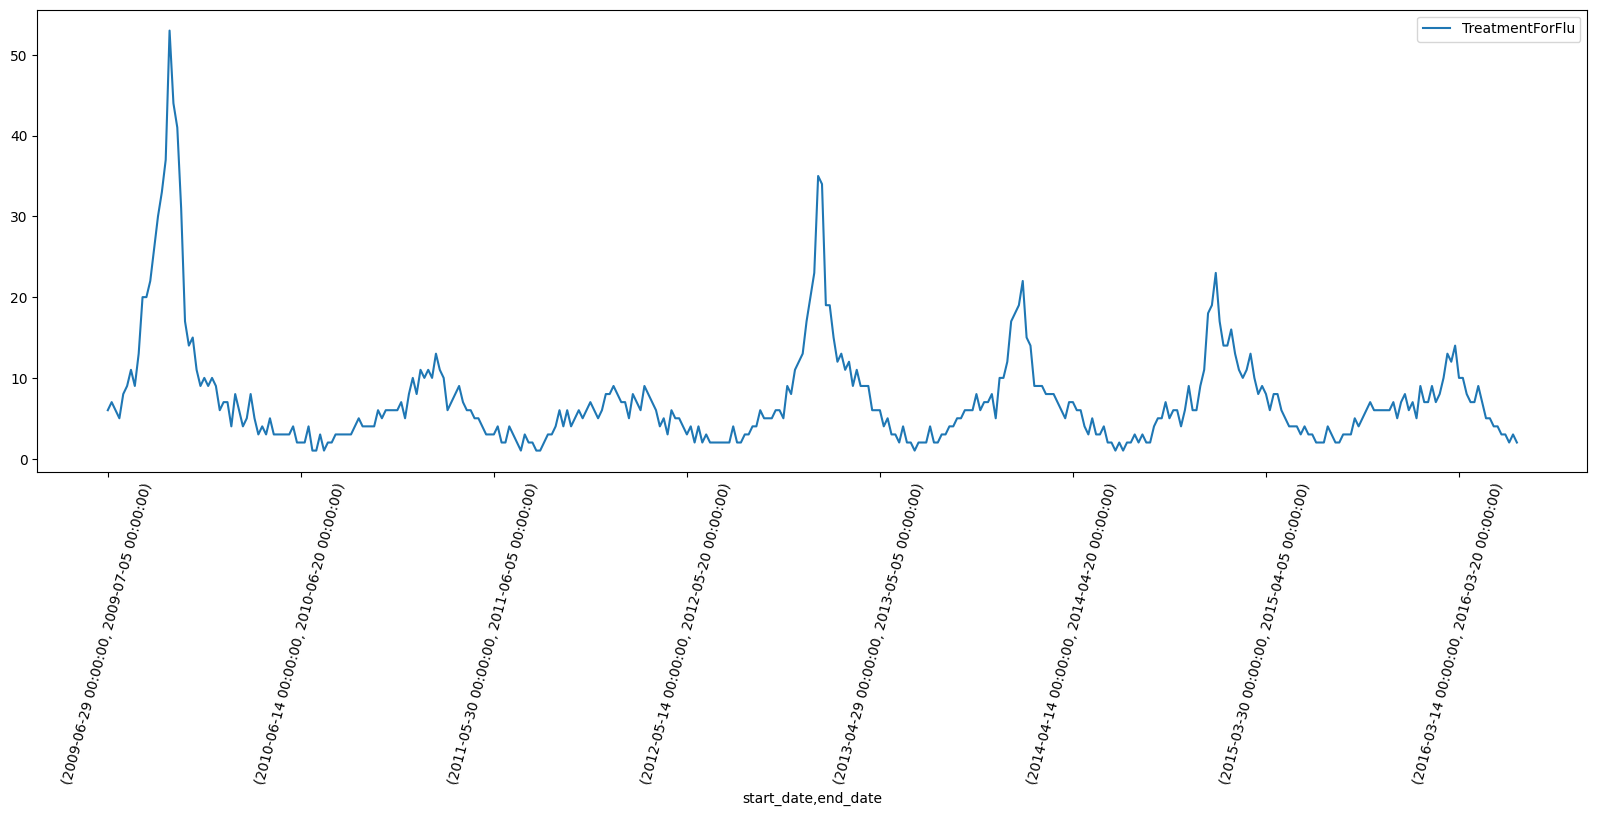

In [58]:
ax = df.plot(y='TreatmentForFlu', use_index=True, figsize=(20, 6))
ax.tick_params(axis='x', rotation=75)
plt.show()

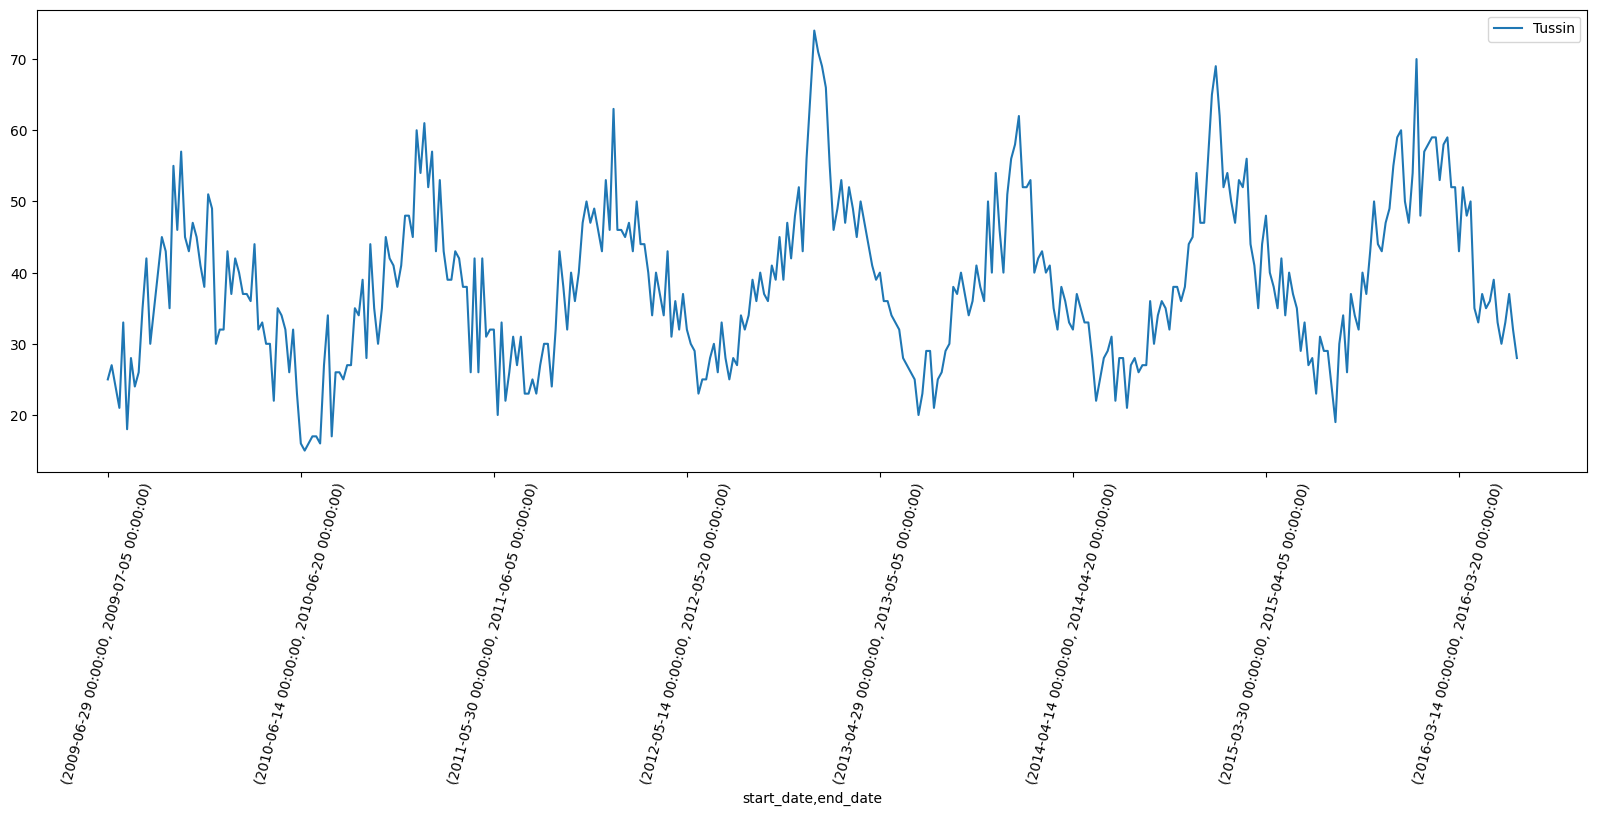

In [59]:
ax = df.plot(y='Tussin', use_index=True, figsize=(20, 6))
ax.tick_params(axis='x', rotation=75)
plt.show()

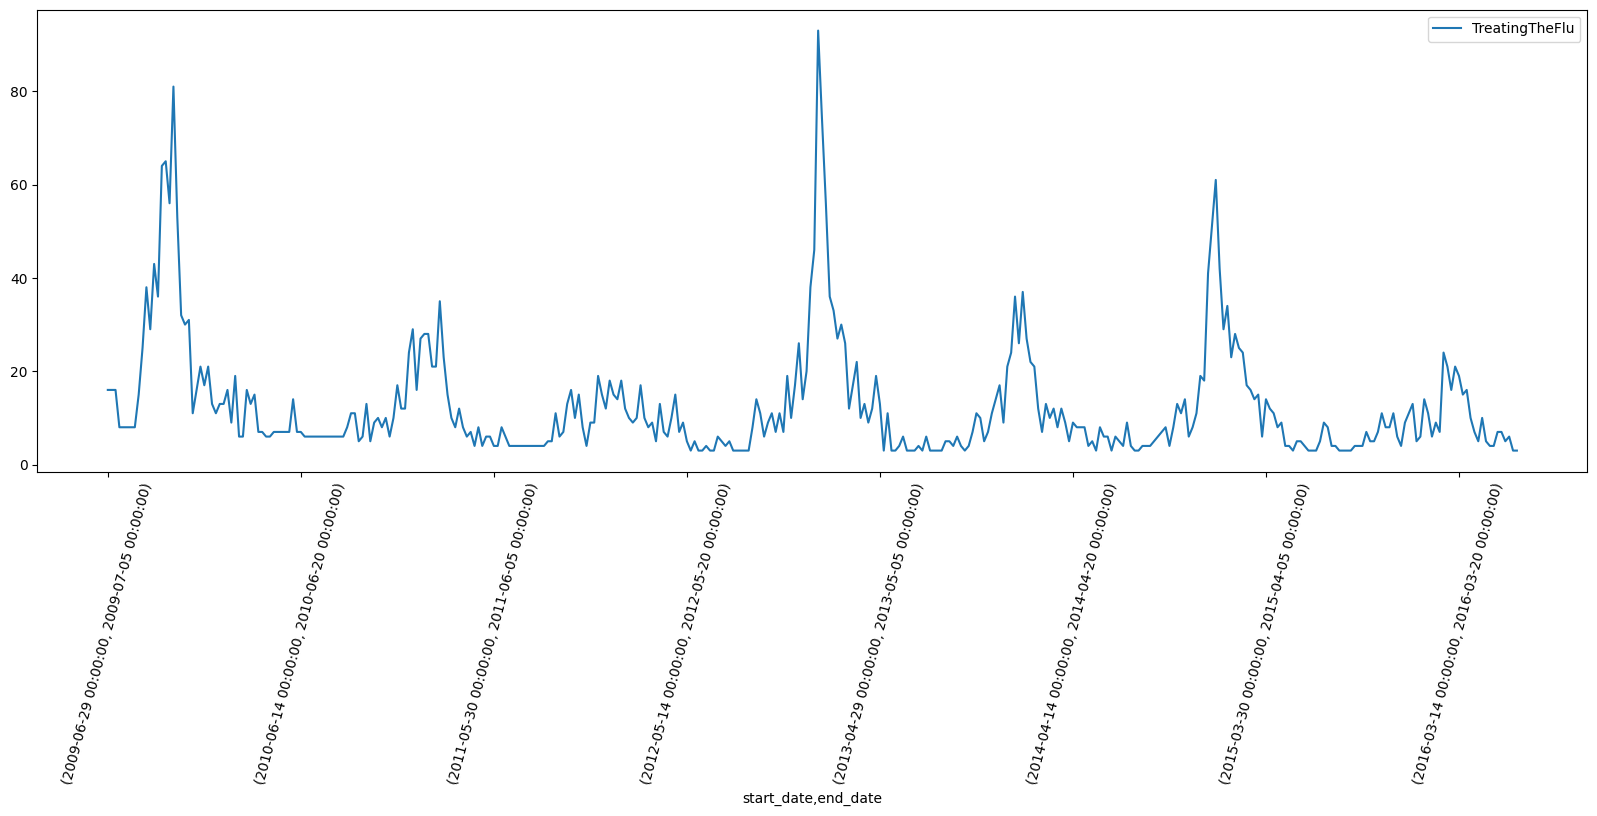

In [60]:
ax = df.plot(y='TreatingTheFlu', use_index=True, figsize=(20, 6))
ax.tick_params(axis='x', rotation=75)
plt.show()

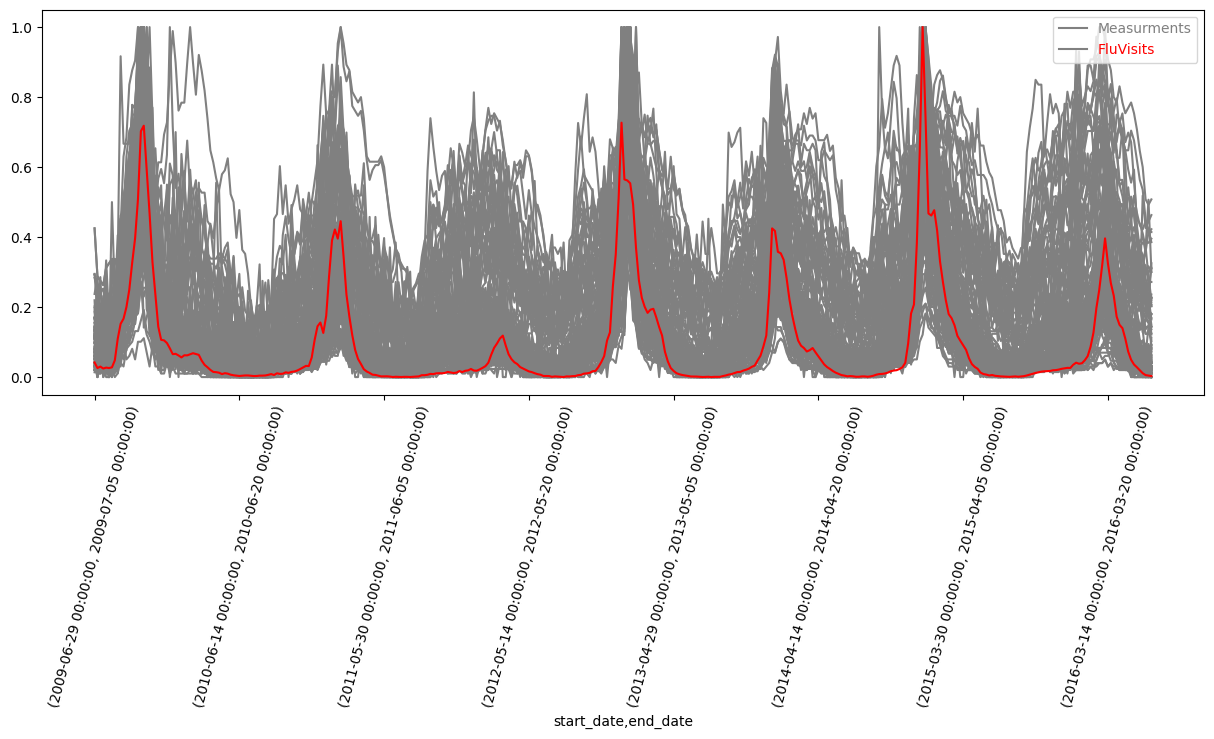

In [63]:
df_norm = (df - df.min()) / (df.max() - df.min())
ax = df_norm.plot(y=df_norm.columns,figsize=(15, 5), color=['gray' for _ in range(len(df_norm.columns)-1)] + ['red'])
ax.legend(["Measurments", "FluVisits"], labelcolor=['gray', 'red'])
ax.tick_params(axis='x', rotation=75)
plt.show()

In [74]:
before_visit = [
    "DoIHaveTheFlu",      
    "EarlyFluSymptoms",    
    "ExposedToFlu",        
    "FeverFlu",            
    "FluTest"              
]
after_visit = [
    "FluTreatment",        
    "FluMedicine",         
    "FluRecovery",         
    "RemediesForFlu",     
    "WhatToDoIfYouHaveTheFlu" 
]

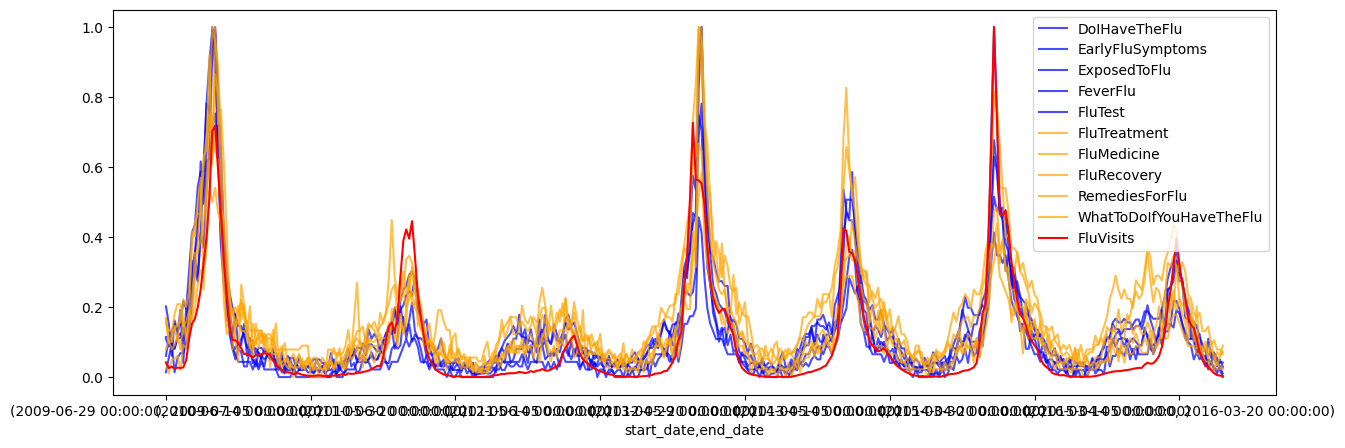

In [75]:
fig, ax= plt.subplots()
df_norm[before_visit].plot(figsize=(15, 5), color='blue', legend=False, ax=ax, label='Before Visit', alpha=0.7)
df_norm[after_visit].plot(figsize=(15, 5), color='orange', legend =False, ax=ax, label='After Visit', alpha=0.7)
df_norm["FluVisits"].plot(figsize=(15, 5), color='red', legend=False, ax=ax, label='FluVisits')
ax.legend()

There are clear seasonal fluctuations in the data with peaks in the flu season. We also had a theory that people might search for flu symptoms before they actually visit the doctor and search for treatments afterwards, which would lead to a slight shift of the peaks. We selected some variables that we thought would show this behavior, but we could not observe it clearly in the last plot. Some Variables like the tussin drug show not a super clear correlation, probably because people search for it when they have a cold or other diseases that can be treated with it too.'

**Task 1.5:** Group the data by month and calculate the average number for each month. Create a bar plot to visualize the monthly averages, which will help identify any seasonal patterns. Check how the number of cases develops over the years.


In [ ]:
start_month = df.index.get_level_values("start_date").month # had to do it like this because of the multi index instead of using the simpler df.index.month directly 
df.groupby(start_month).mean()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
start_date,,,,,,,,,,,,,,,,,,,,,
1,24.166667,60.066667,72.066667,43.200000,39.233333,60.600000,56.500000,45.833333,38.766667,21.633333,...,26.100000,12.933333,25.433333,52.733333,46.300000,28.100000,66.900000,74.433333,25.200000,969.000000
2,20.206897,62.241379,69.586207,38.413793,37.379310,59.068966,53.068966,35.586207,27.896552,14.379310,...,18.482759,9.655172,19.896552,47.862069,39.689655,21.344828,67.517241,67.896552,19.137931,775.931034
3,16.354839,56.677419,62.548387,33.451613,34.322581,52.096774,43.741935,26.258065,18.967742,9.322581,...,12.419355,7.903226,15.677419,41.451613,36.677419,15.903226,62.806452,58.419355,13.419355,534.483871
4,10.166667,46.733333,60.800000,28.533333,26.933333,44.233333,34.800000,18.366667,12.633333,7.066667,...,8.800000,6.100000,13.433333,36.433333,29.200000,9.600000,55.000000,46.666667,11.600000,226.066667
5,5.806452,39.225806,53.451613,25.580645,23.903226,36.903226,29.741935,13.903226,9.064516,5.290323,...,5.645161,3.709677,9.193548,33.032258,25.838710,5.161290,46.096774,40.290323,7.258065,74.774194
6,4.354839,32.709677,47.516129,24.290323,21.258065,29.354839,26.193548,10.516129,6.258065,4.677419,...,5.064516,2.774194,6.612903,26.290323,21.870968,3.870968,41.161290,33.677419,5.258065,30.870968
7,5.866667,26.933333,46.633333,22.833333,18.766667,23.900000,21.833333,8.166667,5.333333,5.433333,...,5.933333,2.666667,5.700000,25.966667,21.766667,5.800000,34.600000,29.733333,5.033333,29.766667
8,7.156250,27.031250,48.843750,23.937500,17.125000,24.625000,24.500000,11.750000,7.468750,6.312500,...,5.312500,3.968750,7.125000,26.968750,23.812500,5.875000,34.718750,31.156250,6.906250,65.093750
9,9.400000,37.833333,66.600000,32.000000,22.066667,36.833333,36.600000,24.333333,16.033333,9.633333,...,10.500000,7.100000,12.333333,34.800000,31.133333,10.600000,52.566667,42.466667,11.866667,168.333333


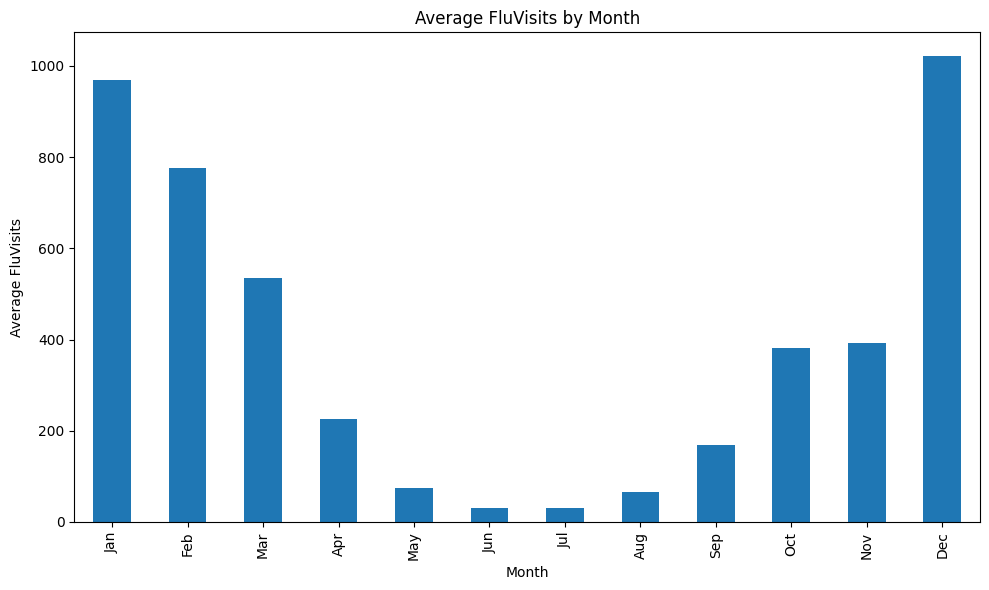

In [73]:

start_month = df.index.get_level_values("start_date").month
monthly_means = df.groupby(start_month)["FluVisits"].mean()

monthly_means.index = monthly_means.index.map({1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"})

ax = monthly_means.plot(kind="bar", figsize=(10,6))
ax.set_xlabel("Month")
ax.set_ylabel("Average FluVisits")
ax.set_title("Average FluVisits by Month")

plt.tight_layout()
plt.show()


There are clear seasonal trends in the data, with peaks in the winter months and decreases of flu visits over the summer months. 

## Task 2: Stationarity and Autocorrelation

**Task 2.1:** Apply the Augmented Dickey-Fuller test to check for stationarity. Explain the results and the implications for time series modeling.

In [ ]:
# first split the Dataset into training, validation and test set so we do not leak information. We will only apply the augmented dickey fuller test on the training.


**Task 2.2:** Investigate Autocorrelation by plotting the Autocorrelation Function (ACF) and the partial Autocorrelation Function (PACF) for the FluVisits column. Determine appropriate values for the AR (p) and MA (q) parameters of the ARIMA model based on these plots.

> Hint: The statsmodels package provides usesful functions for that purpose.  
> If you want to read more about the ACF and PACF, you can check this [link](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/).

Explain your visualizations and findings. Specifically, comment on the trends, seasonality, and autocorrelation. Explain why it is important to do these checks before applying the ARIMA model.

**Task 2.3:** Create lag plots for the FluVisits column to visualize the relationship between the current value and its past values. Comment on the patterns you observe in the lag plots.

## Task 3: Application of the AR(I)MA Model

The ARIMA (AutoRegressive Integrated Moving Average) model is a popular time series forecasting model that combines three components:

1. **AR (AutoRegressive)**: Uses the dependent relationship between an observation and some number of lagged observations.
2. **I (Integrated)**: Represents the differencing of raw observations to allow the time series to become stationary.
3. **MA (Moving Average)**: Uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

ARIMA is denoted as ARIMA(p,d,q), where:
- p: The order of the autoregressive term
- d: The number of differencing required to make the time series stationary
- q: The order of the moving average term

For further information, you can refer to e.g. this [tutorial](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/). 

Many Python packages provide implementations for the ARIMA model, but in this seminar, we will use the [pmdarima](pmdarima) package. The pmdarima package provides an easy-to-use interface for the ARIMA model and automatically selects the best parameters.

**Task 3.1:** Prepare your data for the ARIMA model. In the upcoming days, you will use the years 2015-2016 for testing and therefore you should also get the predictions for these years with the ARIMA model. Prepare the data accordingly. What input is expected by the model?

**Task 3.2:** Use the auto_arima function from the pmdarima package to find the best parameters for the ARIMA model.

**Task 3.3:** Fit the ARIMA model with the best parameters and make predictions for the test set (2015-2016). Evaluate the model using suitable metrics.

**Task 3.4:** Plot the actual vs. predicted values for the test set to visualize the model's performance.

## Optional tasks

- Include search terms as covariates (exogenous features) in the model. Experiment with different combinations of search terms and evaluate the model's performance.
- Apply Facebook's Prophet model to the same dataset and compare its performance with the ARIMA model.